<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<img src='../../pics/banner.PNG'/>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum Computer Vision</h1>

<h2>Doel: Image Processing voor het vereenvoudigen van <i>Features</i></h2>

<img src='../../pics/land_use.png' length=40% width=40%>

<h3>Imports</h3>

In [1]:
from image_filter import ImageFilter
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random
import skimage.measure
import scipy as sp

<h3>Globale variabelen</h3>

In [2]:
riverDirectory = '../../pics/2750/River'
highwayDirectory = '../../pics/2750/Highway'

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://www.kaggle.com/datasets/apollo2506/eurosat-dataset">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=50% width=50%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

<h3>Data Selection</h3>

In [3]:
edgeFiles = list()
print(len(edgeFiles))

for filename in os.listdir(riverDirectory):
    imgFile = os.path.join(riverDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

print(len(edgeFiles))   

0
2500


<h3>Exercise 1</h3>
<p>
    Voeg de directory Highway toe aan de <u>list</u> edgeFiles zodat ook de Highway images worden meegenomen. 
</p>

In [4]:
# Oplossing 
print(len(edgeFiles))   

def edgeFilesSelector(ClassificationType, edgeFilesIN = edgeFiles):
    edgeFilesOut = edgeFilesIN 
    for filename in os.listdir(ClassificationType):
        imgFile = os.path.join(ClassificationType, filename)

        if ".jpg" in imgFile:
            edgeFilesOut.append(imgFile)
    return edgeFilesOut


edgeFilesSelector(highwayDirectory)

print(len(edgeFiles))

2500
5000


<h3>Data Transform</h3>
<p>
Image filters zijn Tensors en om die toe te kunnen passen zetten we de images eerst om naar Tensors m.b.v. Numpy.
</p>    

In [5]:
imageTensors = [ plt.imread(pic).astype(float) for pic in edgeFiles ]
nrOfImages = len(imageTensors)
nrOfImages

5000

<h4>Data Normalising</h4>
<p>Om waardes tussen 0 en 1 te vergrijzgen, delen we door de maximale pixelwaarde</p>

vraag uitleg over deze cell

In [6]:
imageTensors = [ imageTensor/255 for imageTensor in imageTensors ]

<p>
De tensors bevatten alleen de numerieke data van de images, om die te kunnen herleiden tot de oorspronkelijke images hebben we ook een lijst met de corresponderende labels nodig. De labels kunnen we afleiden uit de bestandsnamen.    
</p>    

In [7]:
labelNames, labelNumbers = ([], [])

for i, fileName in enumerate(edgeFiles):
    labelNames.append(fileName.split('/')[4])
    labelNumbers.append(i)

**Controleer de data**

In [8]:
print(f"De eerste Image heeft label {labelNames[0]}")
print(f"De laatste Image heeft label {labelNames[nrOfImages-1]}")

De eerste Image heeft label River
De laatste Image heeft label Highway


<h3>Data visualiseren</h3>

In [9]:
def showImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(4):
        
        # Maak een 2 x 2 raster van Images
        plt.subplot(2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        plt.imshow(imageTensors[i])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 

    plt.show()           

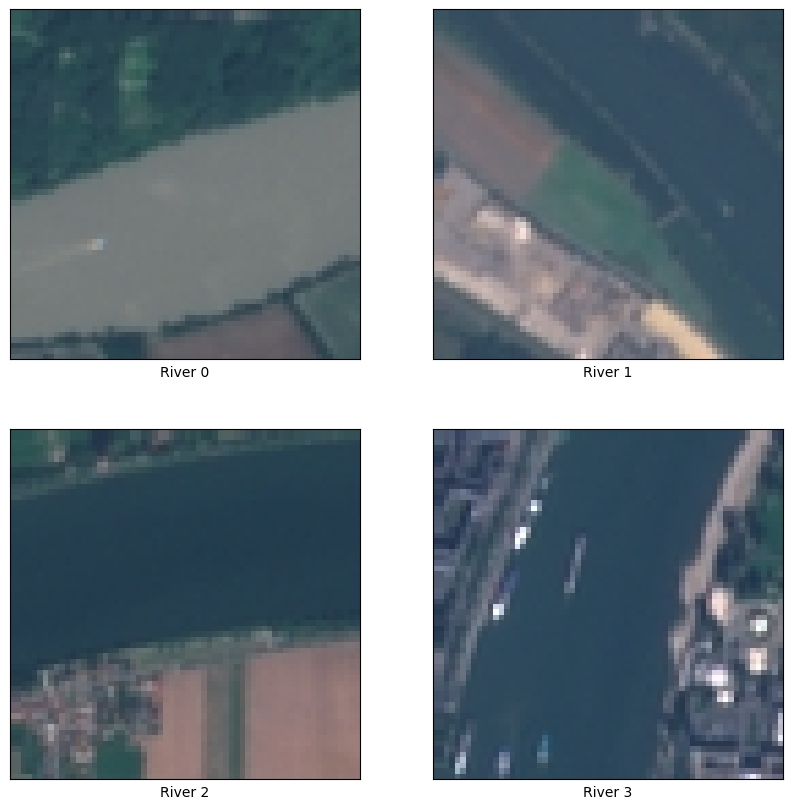

In [10]:
showImages() 

<h3>Exercise 2</h3>
<p>
Maak een nieuwe functie <u>showRandomImages()</u> die <u>16 random</u> images uit de dataset selecteert en weergeeft in een 4 x 4 raster<br>
<strong>Let erop dat bij iedere image het corresponderende label getoond wordt</strong>
</p>

In [11]:
# Oplossing        
# create showRandomImages a change of showImages() that shows 16 random images

def showRandomImages(nrOfRandomImages = 16, shape_h = 4, shape_w = 4):
        
        plt.figure(figsize=(10,10))
        
        
        for i in range(nrOfRandomImages):
            
            # Maak een 4 x 4 raster van Images
            plt.subplot(shape_h, shape_w, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)        
                    
            # Van Tensor terug naar Image met random.randint(0, nrOfImages-1)
            plt.imshow(imageTensors[random.randint(0, nrOfImages-1)])
            
            # Bijbehorende Imagelabel
            plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 
    
        plt.show()

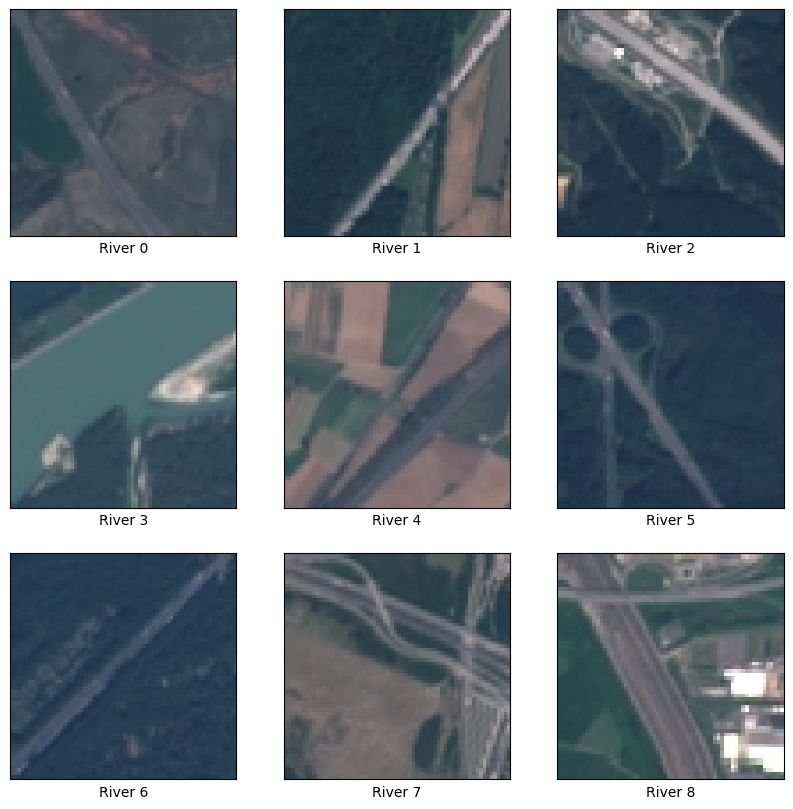

In [12]:
# if () is empty 16 will be shown else: the number added as long as iyt is not greater then 16
showRandomImages(9,3,3)

<h4>Edge Detection</h4>
<p>
Zowel de Highway en River Images hebben randen die relevant zijn om de auto- of waterweg te kunnen onderscheiden van de directe omgeving. We gaan daarom zoveel mogelijk niet-relevante informatie wegfilteren.    
</p>    

<p>Functie voor het genereren van een subplot</p>

In [33]:
def plotImgs(lImg, rImg):
    plt.style.use('dark_background') 
    plt.rcParams["font.size"] = 12
    plt.rcParams["figure.figsize"] = (12, 7)

    fig, (axL, axR) = plt.subplots(ncols=2, constrained_layout=True)
    fig.suptitle(f"{labelNames[labelNumbers[randInd]]} {labelNumbers[randInd]}")
    imL = axL.imshow(np.clip(lImg, 0, 1), interpolation="none")
    imR = axR.imshow(np.clip(rImg, 0, 1), interpolation="none")    

**Definieer de Image Kernel voor de convolutiefiler**

In [14]:
isoTropicFilter = ImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

**Filter de Image**

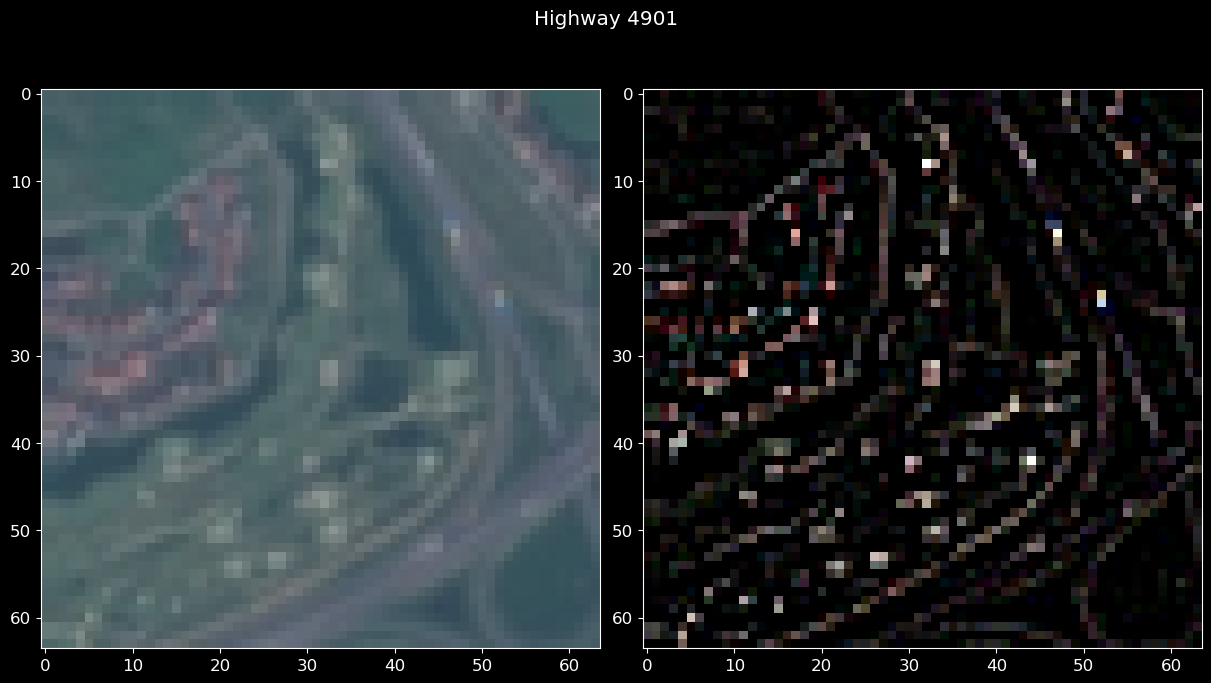

In [15]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, imgFiltered)

<h3>Exercise 3</h3>
<p>
    Maak een 3x3 ImageFilter object <u>horEdgeFilter</u> en voer daarmee een aantal Convoluties uit.<br> 
    Vergelijk de resultaten met die van de Convoluties met de <u>isoTropicFilter</u>
</p>
<p>
    <strong>Tips</strong>
    <ul>
        <li>Op <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing">Wikipedia</a> kun je verschillende filters vinden.</li>
        <li>Schrijf een functie voor <i>batchverwerking</i> op Images.</li>
    </ul>
</p>

In [16]:
horEdgeFilter = ImageFilter( 
    np.array (
        [
            [1, 1, 1], 
            [0,  0, 0], 
            [-1, -1, -1]
        ]
    ) 
)

In [32]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)
imgFiltered2 = horEdgeFilter.convolve(imgOrg)


plotImgs(imgOrg, imgFiltered, imgFiltered2)

TypeError: plotImgs() takes 2 positional arguments but 3 were given

<h3>Exercise 4</h3>
<p>
Voeg aan class ImageFilter de methode <u>downSample()</u> toe waarmee een Image gedownsampled kan worden. Maak gebruik van <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce">block_reduce</a> met een grootte van 2.
</p>

In [18]:
import io
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

class ImageFilter(object):
    
    def __init__(self, kernel=None):
        if kernel is not None:
            self.imgKernel = kernel
    
    def convolve(self, imgTensor):
        imgTensorRGB = imgTensor.copy() 
        outputImgRGB = np.empty_like(imgTensorRGB)

        for dim in range(imgTensorRGB.shape[-1]):  # loop over rgb channels
            outputImgRGB[:, :, dim] = sp.signal.convolve2d (
                imgTensorRGB[:, :, dim], self.imgKernel, mode="same", boundary="symm"
            )

        return outputImgRGB   

    def downSample(self, imgTensor, blockSize=2):
        return skimage.measure.block_reduce(imgTensor, block_size=blockSize, func=np.mean)         

In [30]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]

test = ImageFilter()
img2 = test.downSample(imgOrg)

print (shape(img2))

<class 'numpy.ndarray'>


In [20]:
# get the image
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]

# create 
# # create the filter
filter = ImageFilter(horEdgeFilter)  
img1 = filter.convolve(imgOrg)
# img2 = baseImage.downSample(imgOrg)

# plot the images
plotImgs(imgOrg, imgOrg)


ValueError: convolve2d inputs must both be 2-D arrays

<h2>References</h2>

[Image Kernels Explained Visuall - Victor Powell](https://setosa.io/ev/image-kernels/)<br>